In [2]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset_new_v2 import Dataset, load_dataframes_from_folder, reverse_normalization, normalize_fixed_ranges
from torch.utils.data import DataLoader
from transformer_zerostep_new_v2 import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

In [3]:
# Overall settings
out_dir = "out"
batch_size = 1024

model_name = "ckpt_50pct_recursive_h10_real_val_speed_correction_v2.pt"
# folder_path = '../data/CL_experiments/test/inertia07_ki-0.0061-kp-11.8427'
# folder_path = '../data/CL_experiments/test/inertia04_ki-0.0061-kp-11.8427'
# folder_path = '../../../in-context-bldc/data/simulated/10_percent'
# folder_path = '../../../in-context-bldc/data/simulated/50_percent_longer_steps'
folder_path = '../data/CL_experiments_double_sensor/final_fixed'
# folder_path = '../../../in-context-bldc-data/simulated/50_percent_with_alfa_beta_alt'

# Compute settings
cuda_device = "cuda:0"
no_cuda = False
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
print(torch.cuda.is_available())
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/model_name, map_location=device, weights_only=False)
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx
exp_data["iter_num"]
print(seq_len)
print(exp_data["iter_num"])
print(exp_data['best_val_loss'])
print(exp_data["cfg"])
print(exp_data["cfg"].lr)

False
10
5849
0.0030167651711963117
Namespace(model_dir='out', out_file='ckpt_50pct_recursive_h10_real_val_speed_correction_v2', in_file='ckpt_50pct_recursive_h10_real_val_speed_correction_v2', init_from='resume', seed=42, log_wandb=False, nx=4, nu=5, ny=1, seq_len=10, mag_range=(0.5, 0.97), phase_range=(0.0, 1.5707963267948966), fixed_system=False, n_layer=8, n_head=4, n_embd=16, dropout=0, bias=False, batch_size=128, max_iters=10000, warmup_iters=5000, lr=5e-05, weight_decay=0.0, eval_interval=10, eval_iters=10, fixed_lr=False, threads=16, no_cuda=False, cuda_device='cuda:0', compile=False, beta1=0.9, beta2=0.95, block_size=10, lr_decay_iters=10000, min_lr=5e-06, decay_lr=True, eval_batch_size=128)
5e-05


In [4]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    if k.startswith('module.'):
        state_dict[k[7:]] = v
        state_dict.pop(k)

model.load_state_dict(state_dict)

# plt.figure(figsize=(5,3))
# plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS'][::100], label="loss")
# plt.plot(np.arange(exp_data['iter_num'])[::100], exp_data['LOSS_VAL'][::100], label="val_loss")
# plt.xlabel("Epoch")
# plt.legend()
# plt.show()

size_in_bytes = sum(param.numel() * param.element_size() for param in model.parameters())
size_in_bytes += sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())

# Convert bytes to kilobytes
size_in_kb = size_in_bytes / 1024
print('Model size in KB:', size_in_kb)
H = exp_data["cfg"].seq_len
# Create an instance of the dataset


number of parameters: 0.03M
Model size in KB: 98.12890625


In [5]:
list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I13 = 1.4, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [0, 4, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

['../data/CL_experiments_double_sensor/final_fixed\\inertia05_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia07_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia09_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia11_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia13_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia15_ki-0.0061-kp-11.8427']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia15']
['../data/CL_experiments_double_sensor/final_fixed\\inertia05_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia13_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia15_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia09_ki-0.0061-kp-11.8427', '../data/CL_experiments_double_sensor/final_fixed\\inertia11_ki-0.0061-kp-11.84

33
[-1.44963141e-01 -1.44963141e-01  9.99948118e+02]
29
[-1.44963141e-01 -1.44963141e-01  9.84961709e+02]
14
[-1.44963141e-01 -1.44963141e-01  9.99948118e+02]
9
[-1.44963141e-01 -1.44963141e-01  9.99948118e+02]
30
[-1.44963141e-01 -1.44963141e-01  9.99948118e+02]
15
[-1.44963141e-01 -1.44963141e-01  9.99948118e+02]


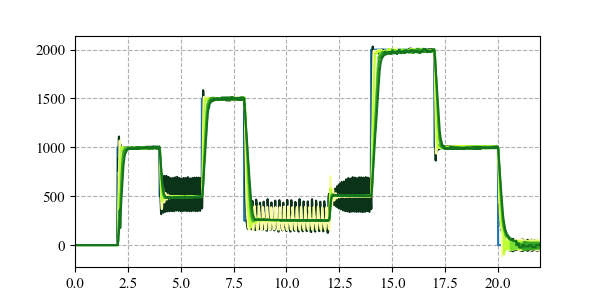

In [6]:
plt.close("all")
plt.figure(figsize=(6,3))

color_palette = ["#0b3319","#15751e","#39a325","#79e230","#c0ff35","#f9fba5"]
for exp_path_idx in range(len(list_of_folders)):
    
    exp_path = list_of_folders[exp_path_idx]

    exp_file_list = glob.glob(os.path.join(exp_path, '*.csv'))

    df = pd.read_csv(exp_file_list[0])
    # df = normalize_fixed_ranges(df)
    

    first_index = df.index[df['r'].diff().gt(0)].min() - 200
    print(first_index)

    df.drop(df.head(first_index-1).index,inplace=True)
    df.drop(df.tail(len(df)-2200).index,inplace=True)
    df['t'] = df['t'].to_numpy() - df['t'].to_numpy()[0]
    # df = df.iloc[first_index: first_index+2200]
    if exp_path_idx ==0:
        plt.plot(df['t'], df['r'])
    plt.plot(df['t'], df['omega'], color = color_palette[-exp_path_idx])
    print(df['r'].to_numpy()[199:202])

plt.show()

In [7]:
list_of_real_values = []
list_of_predictions_tr = []
list_of_predictions_ob = []

for exp_path_idx in range(len(list_of_folders)):
    
    exp_path = list_of_folders[exp_path_idx]

    exp_file_list = glob.glob(os.path.join(exp_path, '*.csv'))

    df = pd.read_csv(exp_file_list[0])
    # df = normalize_fixed_ranges(df)
    

    first_index = df.index[df['r'].diff().gt(0)].min() - 200
    # print(first_index)

    df.drop(df.head(first_index-1).index,inplace=True)
    df.drop(df.tail(len(df)-2200).index,inplace=True)
    df['t'] = df['t'].to_numpy() - df['t'].to_numpy()[0]
    df = normalize_fixed_ranges(df)
    dfs = [df]
    dataset_exp = Dataset(dfs=dfs, seq_len=H)
    dataloader = DataLoader(dataset_exp, batch_size=batch_size, shuffle=True)
    ## test each experiment
    df_len = len(dfs)
    # df_len = 1
    rmse = np.zeros(df_len)
    u_full_all = []
    y_full_all = []
    # y_pred_all = []
    y_obs_all = []
    for i in range(df_len):
        u_full, y_full = dataset_exp.get_full_experiment(i)
        # cut_data
        u_full, y_full = u_full.to(device), y_full.to(device)
        y_obs = dataset_exp.get_experiment_observer(i)
        # u_full, y_full = u_full.to(device)[:1000,:], y_full.to(device)[:1000,:]
        # y_obs = dataset_exp.get_experiment_observer(i)[:1000]
        y_obs_all.append(y_obs)
        # print(y_obs.shape)

        u_full_all.append(u_full)
        y_full_all.append(y_full)

    u_full_all = torch.stack(u_full_all, dim=0)
    y_full_all = torch.stack(y_full_all, dim=0)
    y_pred_all = torch.zeros_like(y_full_all)
    last_omega = torch.zeros((df_len, H, 1)) 
    y_obs_full = np.stack(y_obs_all)



    with torch.no_grad():
        for j in range(y_full_all.shape[1]):
            if j < H:
                input_val = u_full_all[:, :j+1, :]
                input_val[:, :j+1, 4] = last_omega[:,-j-1:,0]

                pred = model(input_val)[:,-1,:]
            else:
                input_val = u_full_all[:,j-H+1:j+1, :]
                input_val[:,:, 4] = last_omega[:,:,0]

                pred = model(input_val)[:,-1,:]
            
            y_pred_all[:,j,0] = pred[:,0]
            last_omega = torch.roll(last_omega, -1, 1)
            last_omega[:,-1,0] = y_pred_all[:,j,0]
        
        u_full_all, y_full_all, y_pred_all  = reverse_normalization(u_full_all, y_full_all, y_pred_all)

    y_full_all_np = y_full_all.cpu().numpy()[:,:,0]
    y_pred_all_np = y_pred_all.cpu().numpy()[:,:,0]

    # print(y_full_all_np[0,:].shape)
    # print(y_pred_all_np[0,:].shape)
    # print(y_obs_full[0].shape)

    list_of_real_values.append(y_full_all_np[0,:])
    list_of_predictions_tr.append(y_pred_all_np[0,:])
    list_of_predictions_ob.append(y_obs_full[0])




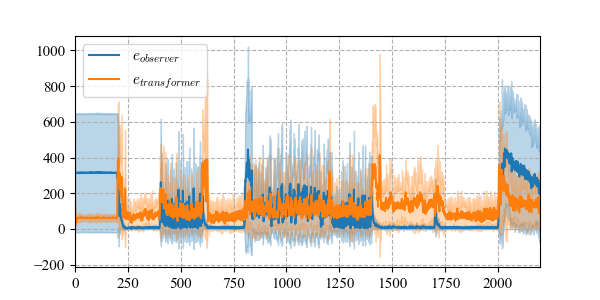

In [ ]:
y_real = np.vstack(list_of_real_values)
y_pred_tr = np.vstack(list_of_predictions_tr)
y_pred_ob = np.vstack(list_of_predictions_ob)


mean_error_tr = np.sqrt(((y_real - y_pred_tr)**2).mean(axis=0))
std_error_tr = np.sqrt(((y_real - y_pred_tr)**2).std(axis=0))

mean_error_obs = np.sqrt(((y_real - y_pred_ob)**2).mean(axis=0))
std_error_obs = np.sqrt(((y_real - y_pred_ob)**2).std(axis=0))

plt.figure(figsize=(6,3))

plt.plot(mean_error_obs, label="$e_{observer}$", color="tab:blue")
plt.fill_between(
    np.arange(mean_error_obs.shape[0]), 
    mean_error_obs + std_error_obs, 
    mean_error_obs - std_error_obs, 
    color='tab:blue', 
    alpha=0.3
)

plt.plot(mean_error_tr, label="$e_{transformer}$", color="tab:orange")
plt.fill_between(
    np.arange(mean_error_tr.shape[0]), 
    mean_error_tr + std_error_tr, 
    mean_error_tr - std_error_tr, 
    color='tab:orange', 
    alpha=0.3
)

plt.legend()


plt.figure(figsize=(6,3))
plt.plot()





plt.show()








